In [1]:
#~40 min
submit = True
if submit:
    LAST_TRAINSET_TIME = 32
else: 
    LAST_TRAINSET_TIME = 29

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode as scipymode
from time import time
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy

totalstart = time()
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_info_columns', 200)

def mode(arr):
    return scipymode(arr)[0][0]

def uniques(arr):
    return len(np.unique(arr))

def non_zero_mean(arr):
    arr = np.array(arr)
    nonzeros = arr[np.nonzero(arr)]
    if len(nonzeros) == 0:
        return 0
    return np.mean(nonzeros)

def non_zero_mean_df(df): # row-wise
    return np.array(df.apply(non_zero_mean, axis=1))

def first_non_zero(arr):
    arr = np.array(arr)
    nonzero_indexes = np.nonzero(arr)[0]
    if len(nonzero_indexes) == 0:
        return 0
    return arr[nonzero_indexes[0]]

def first_non_zero_df(df): # row-wise
    return np.array(df.apply(first_non_zero, axis=1))

In [2]:
if submit:
    data = pd.read_csv('data/monthly_submit.csv')
else:
    data = pd.read_csv('data/monthly_develop.csv')
print(data.head())

   time  shop  item  count   price  revenue  category  item_return_percent
0     0     2    27      1  2499.0   2499.0        19             0.000000
1     0     2    33      1   499.0    499.0        37             0.004854
2     0     2   317      1   299.0    299.0        45             0.000000
3     0     2   438      1   299.0    299.0        45             0.000000
4     0     2   471      2   399.0    798.0        49             0.000000


In [3]:
test = pd.read_csv('data/test.csv').drop('ID', axis=1)
test.columns = ['shop', 'item']
test.head()

,shop,item
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [4]:
data = pd.merge(data, test, how='inner').fillna(0) # limits training data to things asked in test
del test
print(data.head())
len(data)

   time  shop  item  count  price  revenue  category  item_return_percent
0     0     2    33      1  499.0    499.0        37             0.004854
1    10     2    33      2  199.0    398.0        37             0.004854
2    11     2    33      1  199.0    199.0        37             0.004854
3    12     2    33      1  199.0    199.0        37             0.004854
4    20     2    33      1  199.0    199.0        37             0.004854


601749

## Features

- time +
- item +
- shop +
- shop city (sorted by count,alpha) +
- shop type (sorted by count,alpha) +
- category +
- larger category +
- total item return percent +

last 12 months of:  
- item sales in store +
- shop sales +
- shop sales per unique item sold in store that month +
- item sales +
- category sales per unique item sold in category that month +
- category sales in store per unique item sold in category and store that month +
- item price in store +
- item revenue in store +
- 12,6,3 means of 12 month series +


last month's (if useful, try more)
- mean price per item, shop, category +
- mean revenue per item, shop, category +


- year, month, days in month, holidays in month +
- word embeddings of english translated item names (spacy large pretrained, pca) +
- mean target for shop,category,item,shop+item,shop+category (only on train set) (percentiles,median,std?) +
- trend of shopitem/item mean count/price (most recent - avg)/avg (avg=last year avg) +
- how long ago was first/last sale of item/item in store +
- tSNE and PCA components (https://distill.pub/2016/misread-tsne/) (also to EDA) +

In [5]:
start = time()

item_meta = data[['item', 'category', 'item_return_percent']]
item_meta = item_meta.groupby(['item']
                             ).aggregate({'category': mode, 'item_return_percent': mode}).reset_index()

counts = data[['time', 'shop', 'item', 'count', 'price', 'revenue']]
indexcols = ['time', 'shop', 'item']
multiindex = pd.MultiIndex.from_product([np.append(counts['time'].unique(), 34), counts['shop'].unique(), 
                                         counts['item'].unique()], names=indexcols)
counts = counts.set_index(indexcols).reindex(multiindex, fill_value=0).reset_index()

data = pd.merge(counts, item_meta, on='item', how='left').astype(
    {'time': 'int8', 'shop': 'int8', 'item': 'int16', 'count': 'int16', 'price': 'float32', 
     'revenue': 'float32', 'category': 'int8', 'item_return_percent': 'float16'})

del item_meta, counts, multiindex

print(round(time()-start, 1), 's')
data.head()

22.6 s


,time,shop,item,count,price,revenue,category,item_return_percent
0,0,2,33,1,499.0,499.0,37,0.004856
1,0,2,482,1,3300.0,3300.0,73,0.002995
2,0,2,491,1,600.0,600.0,73,0.000000
3,0,2,839,1,3300.0,3300.0,73,0.004116
4,0,2,1007,3,449.0,1347.0,67,0.000000


In [6]:
start = time()
shop_metadata = pd.read_csv('data/shops_translated.csv').drop('Name', axis=1)
shop_metadata.columns = ['shop', 'shop_city', 'shop_type']

cities=shop_metadata['shop_city'].value_counts().reset_index().sort_values(['shop_city','index'],ascending=[False,True])['index']
city_encoder = {}
for i, city in enumerate(cities):
    city_encoder[city] = i
shop_metadata['shop_city'] = shop_metadata['shop_city'].map(city_encoder).astype('int8')

types=shop_metadata['shop_type'].value_counts().reset_index().sort_values(['shop_type','index'],ascending=[False,True])['index']
type_encoder = {}
for i, shop_type in enumerate(types):
    type_encoder[shop_type] = i
shop_metadata['shop_type'] = shop_metadata['shop_type'].map(type_encoder).astype('int8')

data = data.merge(shop_metadata, how='left')
print(round(time()-start, 1), 's')

1.9 s


In [7]:
def category_mapper(c):
    ranges = [[0], range(1,8), [8], [9], range(10,18), range(18,25), [25], range(26,28), range(28,32), range(32,37), 
             range(37,43), range(43,55), range(55,61), range(61,73), range(73,79), range(79,81), range(81,83), [83]]
    for i in range(len(ranges)):
        if c in ranges[i]:
            return i

start = time()
data['larger_category'] = data['category'].map(category_mapper).astype('int8')
print(round(time()-start, 1), 's')

50.4 s


In [8]:
# 12 month lags
start = time()

withlags = data
lags = range(1, 13)

colname = 'count'
for lag in lags:
    lagged = data[['time', 'shop', 'item', 'count']].rename({'count': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged, on=['time', 'shop', 'item'])

withlags[colname+'_12_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname+'_6_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname+'_3_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')

colname1 = 'shop_count'
colname2 = 'shop_count_per_item'
subset = data.groupby(['time', 'shop']).aggregate({'count': np.sum, 'item': uniques}
                                                    ).rename(columns={'item': 'unique_items'}).reset_index()
for lag in lags:
    lagged = subset.rename({'count': colname1+'_lag_{}'.format(lag)}, axis=1)
    lagged[colname2+'_lag_{}'.format(lag)] = (lagged[colname1+'_lag_{}'.format(lag)] / lagged['unique_items']).astype('float16')
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged.drop('unique_items', axis=1), on=['time', 'shop'])
    
withlags[colname1+'_12_mean'] = np.mean(withlags[[colname1+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname1+'_6_mean'] = np.mean(withlags[[colname1+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname1+'_3_mean'] = np.mean(withlags[[colname1+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')
withlags[colname2+'_12_mean']= np.mean(withlags[[colname2+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname2+'_6_mean'] = np.mean(withlags[[colname2+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname2+'_3_mean'] = np.mean(withlags[[colname2+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')

colname = 'item_count'
subset = data.groupby(['time', 'item']).aggregate({'count': np.sum}).reset_index()
for lag in lags:
    lagged = subset.rename({'count': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged, on=['time', 'item'])
    
withlags[colname+'_12_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname+'_6_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname+'_3_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')

colname = 'category_count_per_item'
subset = data.groupby(['time', 'category']).aggregate({'count': np.sum, 'item': uniques}
                                                            ).rename(columns={'item': 'unique_items'}).reset_index()
subset['count'] = (subset['count'] / subset['unique_items']).astype('float16')
for lag in lags:
    lagged = subset.rename({'count': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged.drop('unique_items', axis=1), on=['time', 'category'])
    
withlags[colname+'_12_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname+'_6_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname+'_3_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')

colname = 'shop_category_count_per_item'
subset = data.groupby(['time', 'shop', 'category']).aggregate({'count': np.sum, 'item': uniques}
                                                            ).rename(columns={'item': 'unique_items'}).reset_index()
subset['count'] = (subset['count'] / subset['unique_items']).astype('float16')
for lag in lags:
    lagged = subset.rename({'count': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged.drop('unique_items', axis=1), on=['time', 'shop', 'category'])
    
withlags[colname+'_12_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float16')
withlags[colname+'_6_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float16')
withlags[colname+'_3_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float16')

colname = 'item_price'
subset = data.groupby(['time', 'item']).aggregate({'price': non_zero_mean}).reset_index()

for lag in lags:
    lagged = subset.rename({'price': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged, on=['time', 'item'])

withlags[colname+'_12_mean'] = pd.Series(non_zero_mean_df(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]])
                                        ).astype('float32')
withlags[colname+'_6_mean'] = pd.Series(non_zero_mean_df(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]])
                                        ).astype('float32')
withlags[colname+'_3_mean'] = pd.Series(non_zero_mean_df(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]])
                                        ).astype('float32')

colname = 'revenue'
for lag in lags:
    lagged = data[['time', 'shop', 'item', 'revenue']].rename({'revenue': colname+'_lag_{}'.format(lag)}, axis=1)
    lagged['time'] = lagged['time'] + lag
    withlags = withlags.merge(lagged, on=['time', 'shop', 'item'])

withlags[colname+'_12_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,13)]], axis=1).astype('float32')
withlags[colname+'_6_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,7)]], axis=1).astype('float32')
withlags[colname+'_3_mean'] = np.mean(withlags[[colname+'_lag_{}'.format(i) for i in range(1,4)]], axis=1).astype('float32')

print(round((time()-start)/60, 1), 'min')
start = time()

# 1 month lags
lag=1

for measure in ['price', 'revenue']:
    for groupers in [['shop'], ['category'], ['item']]:
        if measure == 'price' and groupers == ['item']:
            continue # already done
        
        colname = '_'.join(groupers+[measure])
        lagged = data.groupby(by=['time']+groupers).aggregate({measure: np.mean}
                                                        ).rename(columns={measure: colname+'_lag_{}'.format(lag)}).reset_index()
        lagged['time'] = lagged['time'] + lag
        withlags = withlags.merge(lagged, on=['time']+groupers)

data = withlags
del withlags, lagged
print(round(time()-start, 1), 's')

12.7 min
43.7 s


In [9]:
start = time()
data['month'] = (data['time'] % 12).astype('int8')
data['year'] = ((data['time'] - data['month']) / 12).astype('int8')
data['month_length'] = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])[data['month']]
data['month_length'] = data['month_length'].astype('int8')
data['holidays_in_month'] = np.array([6, 3, 2, 8, 3, 3, 2, 8, 4, 8, 5, 4])[data['month']]
data['holidays_in_month'] = data['holidays_in_month'].astype('int8')
print(round(time()-start, 1), 's')

0.2 s


In [10]:
start = time()

nlp = spacy.load('en_core_web_lg')
def get_string_vector(string):
    return nlp(string).vector

items = pd.read_csv('data/item_categories_translated.csv')[['item_id', 'item_name_translated']]
items.columns = ['item', 'item_name']
vectors = [get_string_vector(name) for name in items['item_name']]
vectors = pd.DataFrame(vectors, columns=[str(i) for i in range(300)])

del nlp
print(round((time()-start)/60, 1), 'min')

3.4 min


[0.12365095 0.20853264 0.27241237]
3.9 s


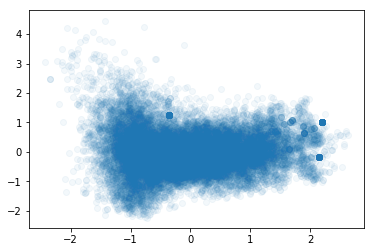

In [11]:
start = time()

n_components = 3
pca = PCA(n_components=n_components)
pca.fit(vectors)
print(np.cumsum(pca.explained_variance_ratio_))
components = pca.transform(vectors)
plt.scatter([c[0] for c in components], [c[1] for c in components], alpha = 0.05)

components = pd.DataFrame(components, columns=['item_name_vector_'+str(i) for i in range(1,n_components+1)]).astype('float16')
components = pd.concat([items['item'], components], axis=1)
data = data.merge(components)
del components

print(round(time()-start, 1), 's')

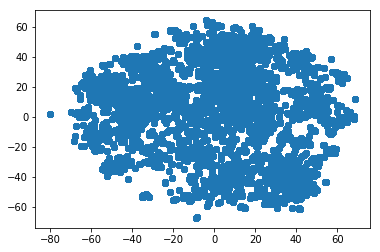

12.7 min


In [12]:
start = time()

n_components = 2
perplexity = 60

tsne = TSNE(n_components=n_components, perplexity=perplexity)
components = tsne.fit_transform(vectors)
components = pd.DataFrame(components, 
                          columns=['item_name_tSNE_vector_'+str(i) for i in range(1,n_components+1)]
                         ).astype('float32')
components = pd.concat([items['item'], components], axis=1)
data = data.merge(components)

plt.scatter(data['item_name_tSNE_vector_1'], data['item_name_tSNE_vector_2'], alpha = 0.05); plt.show()

del tsne, components
print(round((time()-start)/60, 1), 'min')

In [13]:
start = time()
trainset = data[data['time'] <= LAST_TRAINSET_TIME]
combos = [['shop'], ['category'], ['item'], ['shop', 'category'], ['shop', 'item']]

for combo in combos:
    column_name = '_'.join(combo) + '_mean_count'
    combo_data = trainset[['count']+combo]
    combo_data = combo_data.groupby(by=combo).aggregate({'count': np.mean}).rename(columns={'count': column_name}).reset_index()
    data = pd.merge(data, combo_data.astype({column_name: 'float16'}), how='left')

del trainset, combo_data
print(round(time()-start, 1), 's')

66.4 s


In [14]:
start = time()

for lagvariable in ['count', 'item_count', 'item_price']:
    
    avg = data[lagvariable+'_12_mean']
    most_recent = pd.Series(first_non_zero_df(data[[lagvariable+'_lag_{}'.format(i) for i in range(1,7)]]))
    data[lagvariable+'_trend'] = ((most_recent - avg) / avg).fillna(0).astype('float16')

del avg, most_recent
print(round((time()-start)/60, 1), 'min')

4.8 min


In [15]:
#slight leakages here
start = time()

for groupers, varname in [(['item'], 'item_sale'), 
                          (['shop', 'item'], 'sale')]:
    
    subset = data.groupby(by=groupers+['time']).aggregate({'count': np.sum}).reset_index()
    subset['sale'] = subset['count'] > 0
    subset = subset.drop('count', axis=1)
    
    last_df = subset[['time']+groupers]
    subset = pd.pivot_table(subset, index=groupers, columns='time', values='sale').reset_index()
    first_df = subset[groupers]
    subset = subset.drop(groupers, axis=1)
    
    firsts = []
    lasts = []
    for ix in range(len(subset)):
        first = None
        last = 35
        
        for col in range(len(subset.columns)):
            purchase = subset.iloc[ix,col]
            month = 12+col
            
            if purchase and not first:
                first = month
            lasts.append(month-last)
            if purchase:
                last = month
        
        if not first:
            first = 35
        firsts.append(first)
    
    first_df['first_'+varname] = firsts
    data = data.merge(first_df, how='left')
    data['months_since_first_'+varname] = (data['time'] - data['first_'+varname]).astype('int8')
    data = data.drop('first_'+varname, axis=1)
    
    last_df['months_since_last_'+varname] = lasts
    last_df['months_since_last_'+varname] = last_df['months_since_last_'+varname].astype('int8')
    data = data.merge(last_df, how='left')

del subset, last_df, first_df, firsts, lasts

print(round((time()-start)/60, 1), 'min')

4.4 min


In [16]:
# dangerous columns that can hint at label because like the label 
# they contain data only obtainable during the given month
data = data.drop(['revenue', 'price'], axis=1)

In [17]:
data_to_reduce = data.drop('count', axis=1) # try not to leak

In [18]:
#data[['item_name_tSNE_vector_1', 'item_name_tSNE_vector_1']]
data['item_name_tSNE_vector_1'][data['item_name_tSNE_vector_1'].isnull()]

Series([], Name: item_name_tSNE_vector_1, dtype: float32)

[0.34110051 0.13766528 0.0853578  0.05543507]
[0.34110051 0.47876579 0.56412359 0.61955866]


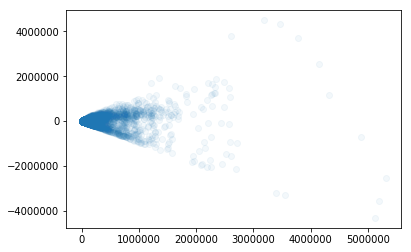

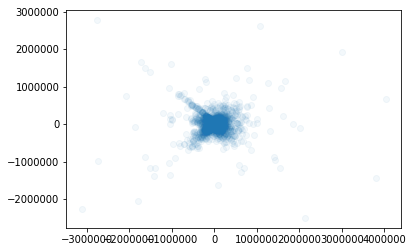

2.5 min


In [19]:
start = time()

n_components = 4
pca = PCA(n_components=n_components)
components = pca.fit_transform(data_to_reduce)
print(pca.explained_variance_ratio_)
print(np.cumsum(pca.explained_variance_ratio_))
components = pd.DataFrame(components, columns=['all_data_PCA_vector_'+str(i) for i in range(1,n_components+1)]).astype('float32')
data = pd.concat([data, components], axis=1)

plt.scatter(data['all_data_PCA_vector_1'], data['all_data_PCA_vector_2'], alpha = 0.05); plt.show()
plt.scatter(data['all_data_PCA_vector_3'], data['all_data_PCA_vector_4'], alpha = 0.05); plt.show()

print(round((time()-start)/60, 1), 'min')

In [20]:
data = data.sort_values(by=['time', 'shop', 'item']).reset_index(drop=True)
data.head()

,time,shop,item,count,category,item_return_percent,shop_city,shop_type,larger_category,count_lag_1,count_lag_2,count_lag_3,count_lag_4,count_lag_5,count_lag_6,count_lag_7,count_lag_8,count_lag_9,count_lag_10,count_lag_11,count_lag_12,count_12_mean,count_6_mean,count_3_mean,shop_count_lag_1,shop_count_per_item_lag_1,shop_count_lag_2,shop_count_per_item_lag_2,shop_count_lag_3,shop_count_per_item_lag_3,shop_count_lag_4,shop_count_per_item_lag_4,shop_count_lag_5,shop_count_per_item_lag_5,shop_count_lag_6,shop_count_per_item_lag_6,shop_count_lag_7,shop_count_per_item_lag_7,shop_count_lag_8,shop_count_per_item_lag_8,shop_count_lag_9,shop_count_per_item_lag_9,shop_count_lag_10,shop_count_per_item_lag_10,shop_count_lag_11,shop_count_per_item_lag_11,shop_count_lag_12,shop_count_per_item_lag_12,shop_count_12_mean,shop_count_6_mean,shop_count_3_mean,shop_count_per_item_12_mean,shop_count_per_item_6_mean,shop_count_per_item_3_mean,item_count_lag_1,item_count_lag_2,item_count_lag_3,item_count_lag_4,item_count_lag_5,item_count_lag_6,item_count_lag_7,item_count_lag_8,item_count_lag_9,item_count_lag_10,item_count_lag_11,item_count_lag_12,item_count_12_mean,item_count_6_mean,item_count_3_mean,category_count_per_item_lag_1,category_count_per_item_lag_2,category_count_per_item_lag_3,category_count_per_item_lag_4,category_count_per_item_lag_5,category_count_per_item_lag_6,category_count_per_item_lag_7,category_count_per_item_lag_8,category_count_per_item_lag_9,category_count_per_item_lag_10,category_count_per_item_lag_11,category_count_per_item_lag_12,category_count_per_item_12_mean,category_count_per_item_6_mean,category_count_per_item_3_mean,shop_category_count_per_item_lag_1,shop_category_count_per_item_lag_2,shop_category_count_per_item_lag_3,shop_category_count_per_item_lag_4,shop_category_count_per_item_lag_5,shop_category_count_per_item_lag_6,shop_category_count_per_item_lag_7,shop_category_count_per_item_lag_8,shop_category_count_per_item_lag_9,shop_category_count_per_item_lag_10,shop_category_count_per_item_lag_11,shop_category_count_per_item_lag_12,shop_category_count_per_item_12_mean,shop_category_count_per_item_6_mean,shop_category_count_per_item_3_mean,item_price_lag_1,item_price_lag_2,item_price_lag_3,item_price_lag_4,item_price_lag_5,item_price_lag_6,item_price_lag_7,item_price_lag_8,item_price_lag_9,item_price_lag_10,item_price_lag_11,item_price_lag_12,item_price_12_mean,item_price_6_mean,item_price_3_mean,revenue_lag_1,revenue_lag_2,revenue_lag_3,revenue_lag_4,revenue_lag_5,revenue_lag_6,revenue_lag_7,revenue_lag_8,revenue_lag_9,revenue_lag_10,revenue_lag_11,revenue_lag_12,revenue_12_mean,revenue_6_mean,revenue_3_mean,shop_price_lag_1,category_price_lag_1,shop_revenue_lag_1,category_revenue_lag_1,item_revenue_lag_1,month,year,month_length,holidays_in_month,item_name_vector_1,item_name_vector_2,item_name_vector_3,item_name_tSNE_vector_1,item_name_tSNE_vector_2,shop_mean_count,category_mean_count,item_mean_count,shop_category_mean_count,shop_item_mean_count,count_trend,item_count_trend,item_price_trend,months_since_first_item_sale,months_since_last_item_sale,months_since_first_sale,months_since_last_sale,all_data_PCA_vector_1,all_data_PCA_vector_2,all_data_PCA_vector_3,all_data_PCA_vector_4
0,12,2,30,0,40,0.000479,14,0,10,0,0,0,0,0,0,1,0,0,1,0,0,0.166626,0.0,0.0,635,0.134644,359,0.076111,281,0.05957,303,0.06427,250,0.053009,242,0.0513,231,0.048981,159,0.033722,169,0.035828,235,0.049835,136,0.028839,248,0.052582,270.75,345.0,425.0,0.057373,0.07312,0.090088,40,35,20,12,16,30,46,45,105,294,424,0,88.93750,25.500000,31.671875,7.062500,5.906250,5.261719,4.027344,4.183594,3.998047,3.976562,4.308594,4.136719,4.363281,3.671875,3.546875,4.542969,5.074219,6.078125,0.045776,0.020035,0.008583,0.014305,0.011444,0.032898,0.032898,0.035767,0.021454,0.014305,0.002861,0.025757,0.022171,0.022171,0.024796,168.530563,168.811111,209.084213,399.000000,399.000000,398.994446,399.000000,390.625,398.383759,393.876770,385.900543,0.000000,337.382416,290.570068

In [21]:
maxes = np.max(data)
[print(dict(maxes[i:i+1])) for i in range(len(maxes))];
# 32 = 2 147 483 648; 16 = 32 768; 8 = 128

{'time': 34.0}
{'shop': 59.0}
{'item': 22167.0}
{'count': 20.0}
{'category': 83.0}
{'item_return_percent': 0.33325195}
{'shop_city': 28.0}
{'shop_type': 6.0}
{'larger_category': 17.0}
{'count_lag_1': 20.0}
{'count_lag_2': 20.0}
{'count_lag_3': 20.0}
{'count_lag_4': 20.0}
{'count_lag_5': 20.0}
{'count_lag_6': 20.0}
{'count_lag_7': 20.0}
{'count_lag_8': 20.0}
{'count_lag_9': 20.0}
{'count_lag_10': 20.0}
{'count_lag_11': 20.0}
{'count_lag_12': 20.0}
{'count_12_mean': 20.0}
{'count_6_mean': 20.0}
{'count_3_mean': 20.0}
{'shop_count_lag_1': 8065.0}
{'shop_count_per_item_lag_1': 1.7099609}
{'shop_count_lag_2': 8065.0}
{'shop_count_per_item_lag_2': 1.7099609}
{'shop_count_lag_3': 8065.0}
{'shop_count_per_item_lag_3': 1.7099609}
{'shop_count_lag_4': 8065.0}
{'shop_count_per_item_lag_4': 1.7099609}
{'shop_count_lag_5': 8065.0}
{'shop_count_per_item_lag_5': 1.7099609}
{'shop_count_lag_6': 8065.0}
{'shop_count_per_item_lag_6': 1.7099609}
{'shop_count_lag_7': 8065.0}
{'shop_count_per_item_lag_7': 

In [22]:
print(data.info(max_cols=1))
print()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555656 entries, 0 to 4555655
Columns: 159 entries, time to all_data_PCA_vector_4
dtypes: float16(66), float32(41), int16(38), int8(14)
memory usage: 1.6 GB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4555656 entries, 0 to 4555655
Data columns (total 159 columns):
time                                    int8
shop                                    int8
item                                    int16
count                                   int16
category                                int8
item_return_percent                     float16
shop_city                               int8
shop_type                               int8
larger_category                         int8
count_lag_1                             int16
count_lag_2                             int16
count_lag_3                             int16
count_lag_4                             int16
count_lag_5                             int16
count_lag_6                      

In [23]:
def column_format(data):
    print('[')
    for i in range(len(data.columns)):
        column = data.columns[i]
        print("'{}',".format(column))
    print(']', end='')

column_format(data)

[
'time',
'shop',
'item',
'count',
'category',
'item_return_percent',
'shop_city',
'shop_type',
'larger_category',
'count_lag_1',
'count_lag_2',
'count_lag_3',
'count_lag_4',
'count_lag_5',
'count_lag_6',
'count_lag_7',
'count_lag_8',
'count_lag_9',
'count_lag_10',
'count_lag_11',
'count_lag_12',
'count_12_mean',
'count_6_mean',
'count_3_mean',
'shop_count_lag_1',
'shop_count_per_item_lag_1',
'shop_count_lag_2',
'shop_count_per_item_lag_2',
'shop_count_lag_3',
'shop_count_per_item_lag_3',
'shop_count_lag_4',
'shop_count_per_item_lag_4',
'shop_count_lag_5',
'shop_count_per_item_lag_5',
'shop_count_lag_6',
'shop_count_per_item_lag_6',
'shop_count_lag_7',
'shop_count_per_item_lag_7',
'shop_count_lag_8',
'shop_count_per_item_lag_8',
'shop_count_lag_9',
'shop_count_per_item_lag_9',
'shop_count_lag_10',
'shop_count_per_item_lag_10',
'shop_count_lag_11',
'shop_count_per_item_lag_11',
'shop_count_lag_12',
'shop_count_per_item_lag_12',
'shop_count_12_mean',
'shop_count_6_mean',
'shop_count_3_me

In [1]:
all_subset = [
    'count', # label, dropped later
    'item', # need for prediction S,S,3,
    'shop', # need for prediction S,S,S,
    'time', # need for prediction 3,S,3,3
    
#    'shop_city', # S,S,S,3x trash candidate, all trash
#    'shop_type', # S,S,S,3x trash candidate, all trash
    'category', # S,S,S,3k trash candidate, cheaps trash
#    'larger_category', # S,S,S,3x trash candidate, all trash
    'item_return_percent', # S,3,-,
    
    'month', # 3,-,-,3 cheap candidate, old cheap
    #'year', # S,S,S,
    #'month_length', # S,S,S,
    #'holidays_in_month', # S,S,S,
    
    #'shop_mean_count', # S,S,33,3
    'category_mean_count', # S,3,S,
    'item_mean_count', # 3,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
    'shop_item_mean_count', # 1,-,-, cheap candidate, old cheap, chosen cheap, best cheap subset
    'shop_category_mean_count', # S,2,-,2 cheap candidate, best cheap subset
    
    'count_trend', # 3,3,-,3 cheap additional
    'item_count_trend', # 2,2,-, cheap candidate
    'item_price_trend', # S,S,S,2k trash candidate
    'months_since_first_item_sale', # 2,3,-, cheap candidate
    'months_since_last_item_sale', # S3,S3,-,3 cheap additional
    'months_since_first_sale', # 2,2,-, cheap candidate
    'months_since_last_sale', # 3,3,-,3
    
#    'item_name_vector_1', # S,S,S32, trash candidate, all trash
#    'item_name_vector_2', # S,S,S3, trash candidate, all trash, cheaps trash
#    'item_name_vector_3', # S,3,33, trash candidate, all trash, cheaps trash
    #'item_name_tSNE_vector_1', # S,S,S32,
    #'item_name_tSNE_vector_2', # S,S,S32,
    'all_data_PCA_vector_1', # S,S,1131, trash candidate
    'all_data_PCA_vector_2', # S,S,223, trash candidate
#    'all_data_PCA_vector_3', # S,3,223, trash candidate, all trash, cheap additional
#    'all_data_PCA_vector_4', # S,S,322, trash candidate, all trash, cheaps trash
    
    #'shop_price_lag_1', # S,S,S,
    #'category_price_lag_1', # S,S,S,
    #'shop_revenue_lag_1', # S,S,
    #'category_revenue_lag_1', # S,S,S,
    'item_revenue_lag_1', # S,S,2 trash candidate
    
    'count_lag_1', # 1,-,-,1 cheap candidate, old cheap, best cheap subset
    'count_lag_2', # S,-,-,2 cheap candidate, old cheap, chosen cheap
    'count_lag_3', # S,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
    #'count_lag_4', # S,S,2211,
    #'count_lag_5', # S,S,3,3x
    #'count_lag_6', # S,S,3,2
    #'count_lag_7', # S,S,SS33,3
    #'count_lag_8', # S,S,32,2
    #'count_lag_9', # S,S,S,33
    #'count_lag_10', # S,S,S,
    #'count_lag_11', # S,S,S,
    #'count_lag_12', # S,S,S,3
    'count_12_mean', # 3,1,-, cheap candidate, best cheap subset
    'count_6_mean', # 2,-,-, cheap candidate, old cheap
    'count_3_mean', # 1,-,-, cheap candidate, old cheap
    
    'item_count_lag_1', # 3,-,-,21 cheap candidate, old cheap
    #'item_count_lag_2', # S,S,2213,
    #'item_count_lag_3', # S,S,3,3
    #'item_count_lag_4', # 
    #'item_count_lag_5', # 
    'item_count_lag_6', # S,S,SS3, trash candidate
    #'item_count_lag_7', # 
    #'item_count_lag_8', # 
    #'item_count_lag_9', # 
    #'item_count_lag_10', # 
    #'item_count_lag_11', # 
#    'item_count_lag_12', # S,S,S,3 trash candidate, all trash, cheaps trash
    'item_count_12_mean', # 3,3,S, cheap candidate
    'item_count_6_mean', # 3,S,2212 cheap candidate, best cheap subset
    'item_count_3_mean', # S,2,-,
    
    #'shop_count_lag_1', # S,S,S,
    #'shop_count_lag_2', # S,S,S,
    #'shop_count_lag_3', # S,S,S,
    #'shop_count_lag_4', # 
    #'shop_count_lag_5', # 
    #'shop_count_lag_6', # S,S,S,
    #'shop_count_lag_7', # 
    #'shop_count_lag_8', # 
    #'shop_count_lag_9', # 
    #'shop_count_lag_10', # 
    #'shop_count_lag_11', # 
    'shop_count_lag_12', # S,S,S,32x
    #'shop_count_12_mean', # S,S,S,
    #'shop_count_6_mean', # S,S,S,
    #'shop_count_3_mean', # S,S,S,
    
    'shop_count_per_item_lag_1', # S,S,SSS2, trash candidate
    #'shop_count_per_item_lag_2', # S,S,S,
    #'shop_count_per_item_lag_3', # S,S,S,
    #'shop_count_per_item_lag_4', # 
    #'shop_count_per_item_lag_5', # 
    #'shop_count_per_item_lag_6', # S,S,S,
    #'shop_count_per_item_lag_7', # 
    #'shop_count_per_item_lag_8', # 
    #'shop_count_per_item_lag_9', # 
    #'shop_count_per_item_lag_10', # 
    #'shop_count_per_item_lag_11', # 
    'shop_count_per_item_lag_12', # S,S,33,3
    'shop_count_per_item_12_mean', # S,S,SSS3,3X
    #'shop_count_per_item_6_mean', # S,S,S,
    #'shop_count_per_item_3_mean', # S,S,S,
    
    'category_count_per_item_lag_1', # S,S,3,
    #'category_count_per_item_lag_2', # S,S,SSS2,
    #'category_count_per_item_lag_3', # S,S,S,
    #'category_count_per_item_lag_4', # 
    #'category_count_per_item_lag_5', # 
    #'category_count_per_item_lag_6', # S,S,S,
    #'category_count_per_item_lag_7', # 
    #'category_count_per_item_lag_8', # 
    #'category_count_per_item_lag_9', # 
    #'category_count_per_item_lag_10', # 
    #'category_count_per_item_lag_11', # 
    #'category_count_per_item_lag_12', # S,S,S,
    'category_count_per_item_12_mean', # S,S,S,2x
#    'category_count_per_item_6_mean', # S,S,SSS2, trash candidate, all trash
    'category_count_per_item_3_mean', # S,S,SSS2,
    
    'shop_category_count_per_item_lag_1', # S,32,-,2 cheap candidate, best cheap subset
    #'shop_category_count_per_item_lag_2', # S,S,2
    #'shop_category_count_per_item_lag_3', # S,S,S33,
    #'shop_category_count_per_item_lag_4', # 
    #'shop_category_count_per_item_lag_5', # 
    #'shop_category_count_per_item_lag_6', # S,S,S,
    #'shop_category_count_per_item_lag_7', # 
    #'shop_category_count_per_item_lag_8', # 
    #'shop_category_count_per_item_lag_9', # 
    #'shop_category_count_per_item_lag_10', # 
    #'shop_category_count_per_item_lag_11', # 
    #'shop_category_count_per_item_lag_12', # S,S,S,
    'shop_category_count_per_item_12_mean', # S,S,233,
#    'shop_category_count_per_item_6_mean', # S,S,2,3 trash candidate, all trash
    'shop_category_count_per_item_3_mean', # S,3,-,2x cheap candidate, best cheap subset
    
#    'item_price_lag_1', # S,S,S,3 trash candidate, all trash, cheap additional
#    'item_price_lag_2', # S3,S,-,2 trash candidate, all trash, cheaps trash
#    'item_price_lag_3', # S,S,2,2 trash candidate, all trash
    #'item_price_lag_4', # 
    #'item_price_lag_5', # 
#    'item_price_lag_6', # S,S,S,3x trash candidate, all trash
    #'item_price_lag_7', # 
    #'item_price_lag_8', # 
    #'item_price_lag_9', # 
    #'item_price_lag_10', # 
    #'item_price_lag_11', # 
    #'item_price_lag_12', # S,S,S,
    'item_price_12_mean', # 2,2,-, cheap candidate, best cheap subset
    'item_price_6_mean', # S3,3,-,3 cheap candidate
    'item_price_3_mean', # S,S,2,2 cheap additional
    
    'revenue_lag_1', # S,1,-,3 cheap candidate, chosen cheap, best cheap subset
    #'revenue_lag_2', # S,S,23
    #'revenue_lag_3', # S,S,S,
    #'revenue_lag_4', # 
    #'revenue_lag_5', # 
    #'revenue_lag_6', # S,S,S,
    #'revenue_lag_7', # 
    #'revenue_lag_8', # 
    #'revenue_lag_9', # 
    #'revenue_lag_10', # 
    #'revenue_lag_11', # 
    #'revenue_lag_12', # S,S,S,
#    'revenue_12_mean', # S,3,-, thrash candidate, all trash
    #'revenue_6_mean', # S,3,-,
    'revenue_3_mean' # S,2,-,1 cheap candidate
]

minus_cheaps_subset = [
    'count', # label, dropped later
    'item', # need for prediction S,S,3,
    'shop', # need for prediction S,S,S,
    'time', # need for prediction 3,S,3,3
    
    'shop_city', # S,S,S,3x trash candidate, all trash
    'shop_type', # S,S,S,3x trash candidate, all trash
#    'category', # S,S,S,3k trash candidate, cheaps trash
    'larger_category', # S,S,S,3x trash candidate, all trash
    'item_return_percent', # S,3,-,
    
    'month', # 3,-,-,3 cheap candidate, old cheap
    #'year', # S,S,S,
    #'month_length', # S,S,S,
    #'holidays_in_month', # S,S,S,
    
    #'shop_mean_count', # S,S,33,3
    'category_mean_count', # S,3,S,
#    'item_mean_count', # 3,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
#    'shop_item_mean_count', # 1,-,-, cheap candidate, old cheap, chosen cheap, best cheap subset
    'shop_category_mean_count', # S,2,-,2 cheap candidate, best cheap subset
    
#    'count_trend', # 3,3,-,3 cheap additional
    'item_count_trend', # 2,2,-, cheap candidate
    'item_price_trend', # S,S,S,2k trash candidate
    'months_since_first_item_sale', # 2,3,-, cheap candidate
#    'months_since_last_item_sale', # S3,S3,-,3 cheap additional
    'months_since_first_sale', # 2,2,-, cheap candidate
    'months_since_last_sale', # 3,3,-,3
    
    'item_name_vector_1', # S,S,S32, trash candidate, all trash
#    'item_name_vector_2', # S,S,S3, trash candidate, all trash, cheaps trash
#    'item_name_vector_3', # S,3,33, trash candidate, all trash, cheaps trash
    #'item_name_tSNE_vector_1', # S,S,S32,
    #'item_name_tSNE_vector_2', # S,S,S32,
    'all_data_PCA_vector_1', # S,S,1131, trash candidate
    'all_data_PCA_vector_2', # S,S,223, trash candidate
#    'all_data_PCA_vector_3', # S,3,223, trash candidate, all trash, cheap additional
#    'all_data_PCA_vector_4', # S,S,322, trash candidate, all trash, cheaps trash
    
    #'shop_price_lag_1', # S,S,S,
    #'category_price_lag_1', # S,S,S,
    #'shop_revenue_lag_1', # S,S,
    #'category_revenue_lag_1', # S,S,S,
    'item_revenue_lag_1', # S,S,2 trash candidate
    
    'count_lag_1', # 1,-,-,1 cheap candidate, old cheap, best cheap subset
#    'count_lag_2', # S,-,-,2 cheap candidate, old cheap, chosen cheap
#    'count_lag_3', # S,-,-,2 cheap candidate, old cheap, chosen cheap, best cheap subset
    #'count_lag_4', # S,S,2211,
    #'count_lag_5', # S,S,3,3x
    #'count_lag_6', # S,S,3,2
    #'count_lag_7', # S,S,SS33,3
    #'count_lag_8', # S,S,32,2
    #'count_lag_9', # S,S,S,33
    #'count_lag_10', # S,S,S,
    #'count_lag_11', # S,S,S,
    #'count_lag_12', # S,S,S,3
    'count_12_mean', # 3,1,-, cheap candidate, best cheap subset
    'count_6_mean', # 2,-,-, cheap candidate, old cheap
    'count_3_mean', # 1,-,-, cheap candidate, old cheap
    
    'item_count_lag_1', # 3,-,-,21 cheap candidate, old cheap
    #'item_count_lag_2', # S,S,2213,
    #'item_count_lag_3', # S,S,3,3
    #'item_count_lag_4', # 
    #'item_count_lag_5', # 
    'item_count_lag_6', # S,S,SS3, trash candidate
    #'item_count_lag_7', # 
    #'item_count_lag_8', # 
    #'item_count_lag_9', # 
    #'item_count_lag_10', # 
    #'item_count_lag_11', # 
#    'item_count_lag_12', # S,S,S,3 trash candidate, all trash, cheaps trash
    'item_count_12_mean', # 3,3,S, cheap candidate
    'item_count_6_mean', # 3,S,2212 cheap candidate, best cheap subset
    'item_count_3_mean', # S,2,-,
    
    #'shop_count_lag_1', # S,S,S,
    #'shop_count_lag_2', # S,S,S,
    #'shop_count_lag_3', # S,S,S,
    #'shop_count_lag_4', # 
    #'shop_count_lag_5', # 
    #'shop_count_lag_6', # S,S,S,
    #'shop_count_lag_7', # 
    #'shop_count_lag_8', # 
    #'shop_count_lag_9', # 
    #'shop_count_lag_10', # 
    #'shop_count_lag_11', # 
    'shop_count_lag_12', # S,S,S,32x
    #'shop_count_12_mean', # S,S,S,
    #'shop_count_6_mean', # S,S,S,
    #'shop_count_3_mean', # S,S,S,
    
    'shop_count_per_item_lag_1', # S,S,SSS2, trash candidate
    #'shop_count_per_item_lag_2', # S,S,S,
    #'shop_count_per_item_lag_3', # S,S,S,
    #'shop_count_per_item_lag_4', # 
    #'shop_count_per_item_lag_5', # 
    #'shop_count_per_item_lag_6', # S,S,S,
    #'shop_count_per_item_lag_7', # 
    #'shop_count_per_item_lag_8', # 
    #'shop_count_per_item_lag_9', # 
    #'shop_count_per_item_lag_10', # 
    #'shop_count_per_item_lag_11', # 
    'shop_count_per_item_lag_12', # S,S,33,3
    'shop_count_per_item_12_mean', # S,S,SSS3,3X
    #'shop_count_per_item_6_mean', # S,S,S,
    #'shop_count_per_item_3_mean', # S,S,S,
    
    'category_count_per_item_lag_1', # S,S,3,
    #'category_count_per_item_lag_2', # S,S,SSS2,
    #'category_count_per_item_lag_3', # S,S,S,
    #'category_count_per_item_lag_4', # 
    #'category_count_per_item_lag_5', # 
    #'category_count_per_item_lag_6', # S,S,S,
    #'category_count_per_item_lag_7', # 
    #'category_count_per_item_lag_8', # 
    #'category_count_per_item_lag_9', # 
    #'category_count_per_item_lag_10', # 
    #'category_count_per_item_lag_11', # 
    #'category_count_per_item_lag_12', # S,S,S,
    'category_count_per_item_12_mean', # S,S,S,2x
    'category_count_per_item_6_mean', # S,S,SSS2, trash candidate, all trash
    'category_count_per_item_3_mean', # S,S,SSS2,
    
    'shop_category_count_per_item_lag_1', # S,32,-,2 cheap candidate, best cheap subset
    #'shop_category_count_per_item_lag_2', # S,S,2
    #'shop_category_count_per_item_lag_3', # S,S,S33,
    #'shop_category_count_per_item_lag_4', # 
    #'shop_category_count_per_item_lag_5', # 
    #'shop_category_count_per_item_lag_6', # S,S,S,
    #'shop_category_count_per_item_lag_7', # 
    #'shop_category_count_per_item_lag_8', # 
    #'shop_category_count_per_item_lag_9', # 
    #'shop_category_count_per_item_lag_10', # 
    #'shop_category_count_per_item_lag_11', # 
    #'shop_category_count_per_item_lag_12', # S,S,S,
    'shop_category_count_per_item_12_mean', # S,S,233,
    'shop_category_count_per_item_6_mean', # S,S,2,3 trash candidate, all trash
    'shop_category_count_per_item_3_mean', # S,3,-,2x cheap candidate, best cheap subset
    
#    'item_price_lag_1', # S,S,S,3 trash candidate, all trash, cheap additional
#    'item_price_lag_2', # S3,S,-,2 trash candidate, all trash, cheaps trash
    'item_price_lag_3', # S,S,2,2 trash candidate, all trash
    #'item_price_lag_4', # 
    #'item_price_lag_5', # 
    'item_price_lag_6', # S,S,S,3x trash candidate, all trash
    #'item_price_lag_7', # 
    #'item_price_lag_8', # 
    #'item_price_lag_9', # 
    #'item_price_lag_10', # 
    #'item_price_lag_11', # 
    #'item_price_lag_12', # S,S,S,
    'item_price_12_mean', # 2,2,-, cheap candidate, best cheap subset
    'item_price_6_mean', # S3,3,-,3 cheap candidate
#    'item_price_3_mean', # S,S,2,2 cheap additional
    
#    'revenue_lag_1', # S,1,-,3 cheap candidate, chosen cheap, best cheap subset
    #'revenue_lag_2', # S,S,23
    #'revenue_lag_3', # S,S,S,
    #'revenue_lag_4', # 
    #'revenue_lag_5', # 
    #'revenue_lag_6', # S,S,S,
    #'revenue_lag_7', # 
    #'revenue_lag_8', # 
    #'revenue_lag_9', # 
    #'revenue_lag_10', # 
    #'revenue_lag_11', # 
    #'revenue_lag_12', # S,S,S,
    'revenue_12_mean', # S,3,-, thrash candidate, all trash
    #'revenue_6_mean', # S,3,-,
    'revenue_3_mean' # S,2,-,1 cheap candidate
]

In [25]:
start = time()
if submit:
    #data.to_pickle('data/features_submit.p')
    data[all_subset].to_pickle('data/features_submit_all.p')
    data[minus_cheaps_subset].to_pickle('data/features_submit_minus_cheaps.p')
else:
    #data.to_pickle('data/features_develop.p')
    data[all_subset].to_pickle('data/features_develop_all.p')
    data[minus_cheaps_subset].to_pickle('data/features_develop_minus_cheaps.p')
print(round(time()-start, 1), 's')

10.7 s


In [26]:
print('total time:', round((time()-totalstart)/60, 1), 'min')

total time: 44.3 min


47